In [312]:
##Boston Housing Price determined by local factors
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats

import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.compat import lzip

from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict, KFold, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

%matplotlib inline
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) 

# Load the data
df = pd.read_csv('Desktop\\HousingPrice\\BostonHousing.csv')
X = df.drop('medv', axis=1)
Y = df.medv
df.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [313]:
print(df.shape)
print(df.isnull().sum())
df.describe()

(506, 14)
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


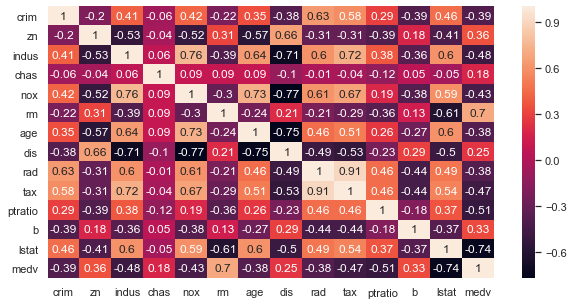

In [314]:
#Next, we create a correlation matrix that measures the linear relationships between the variables using heatmap function from seaborn lib
cor_matrix = df.corr().round(2)
sns.set(rc={'figure.figsize':(10, 5)})
sns.heatmap(data = cor_matrix, annot = True) # annot = True to print the values inside the square
plt.show()

In [315]:
correlated_features = set()
correlation_matrix = df.drop('medv', axis=1).corr() ## Exclude dependent variable from the matrix because you want to check correlation between independent variables

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'tax'}


In [316]:
# Next we standardize the X variables to bring them onto the same scale
X_column_names = X.columns # Get column names first
scaler = StandardScaler() # Create the Scaler object
X = scaler.fit_transform(X) #Fit your data on the scaler object
X = pd.DataFrame(X, columns= X_column_names)

## We will split the data into 80:20 ratio for train and test sample 
#x_train, x_test, y_train, y_test = train_test_split(df.drop('medv', axis=1), df['medv'], test_size=0.3, random_state = 15 )
x_train, x_test, y_train, y_test = train_test_split(X, df['medv'], test_size=0.3, random_state = 15)
x_test.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
301,-0.416401,0.971543,-0.736372,-0.272599,-1.051242,0.435042,-1.001916,0.806539,-0.293081,-0.470612,-1.089110,0.428443,-0.441977
262,-0.359987,0.370669,-1.045700,-0.272599,0.797361,3.010825,0.815230,-0.716164,-0.523001,-0.856665,-2.522434,0.330970,-0.945201


In [317]:
# Now we will compare different Feature selection methods to select our independent variables
# Random Forest Regressor feature selection method
#predictor_names = np.array(['crim', 'zn', 'indus', 'chas', 'nox','rm', 'age', 'dis','rad', 'tax', 'ptratio', 'b', 'lstat'])
predictor_names = ['crim', 'zn', 'indus', 'chas', 'nox','rm', 'age', 'dis','rad', 'tax', 'ptratio', 'b', 'lstat']
rf = RandomForestRegressor()
rf.fit(x_train, y_train.ravel())
print("Predictors sorted by their score:")
z = sorted(zip (map(lambda z: round(z, 5), rf.feature_importances_), predictor_names), reverse=True)
z

Predictors sorted by their score:


[(0.42484, 'rm'),
 (0.42222, 'lstat'),
 (0.04634, 'dis'),
 (0.02409, 'nox'),
 (0.02077, 'ptratio'),
 (0.01432, 'age'),
 (0.01361, 'crim'),
 (0.01096, 'b'),
 (0.0093, 'tax'),
 (0.00682, 'indus'),
 (0.00441, 'rad'),
 (0.00174, 'chas'),
 (0.00056, 'zn')]

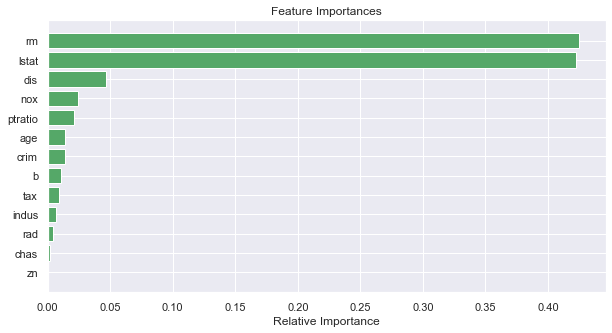

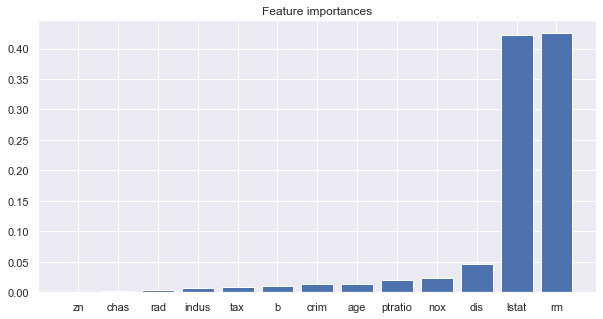

In [318]:
#plot
importance = rf.feature_importances_
indices = np.argsort(importance)
plt.figure()
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.barh(range(len(indices)), importance[indices], color='g', align='center')
#plt.yticks(range(len(indices)), predictor_names[indices])
plt.yticks(range(len(indices)), x_train.columns[indices])
plt.show()

# Vertical plot
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importance[indices], color="b", align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices])
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [319]:
## Recursive Feature Elimination (RFE) feature selection method
model = LinearRegression()
rfe_model = RFE(model, 8)
rfe_fit = rfe_model.fit(x_train, y_train)

print(rfe_fit.ranking_)
print(rfe_fit.support_)

#temp = pd.Series(rfe_fit.support_, index = predictor_names)
temp = pd.Series(rfe_fit.support_, index = x_train.columns)
selected_features_rfe = temp[temp==True].index
print("The selected features as per RFE method are", selected_features_rfe)

[4 1 3 6 1 1 5 1 1 1 1 2 1]
[False  True False False  True  True False  True  True  True  True False
  True]
The selected features as per RFE method are Index(['zn', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat'], dtype='object')


In [320]:
## RFECV feature selection method
lr = LinearRegression()
#rfecv = RFECV(estimator=lr, step=1, scoring='neg_mean_squared_error')
rfecv = RFECV(estimator=lr, step=1, scoring='r2')
rfecv_fit = rfecv.fit(x_train, y_train) # Fit recursive feature eliminator
#rfecv_fit = rfecv_fit.transform(x_train) # Recursive feature elimination

print('Optimal number of features :', rfecv_fit.n_features_)  #rfecv_fit.n_features_ gives number of best features
print('Best features :', x_train.columns[rfecv_fit.support_]) #rfecv_fit.support_  gives names of best features

Optimal number of features : 13
Best features : Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')


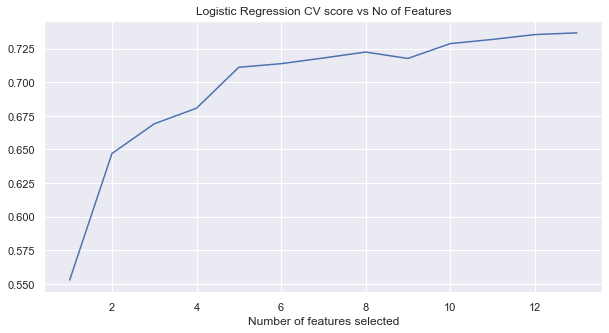

In [321]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_fit.grid_scores_) + 1), rfecv_fit.grid_scores_)
plt.show()

Best alpha using built-in LassoCV: 0.042093
Best score using built-in LassoCV: 0.759956
Lasso picked 13 variables and eliminated other 0 variables


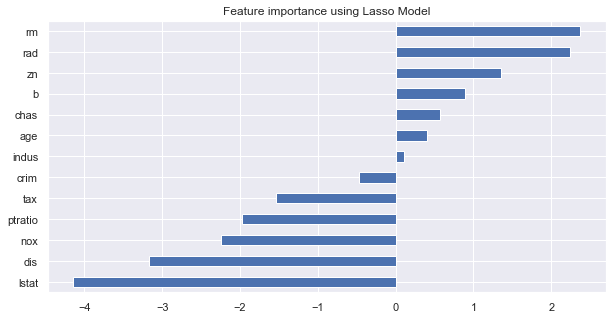

In [322]:
## LASSO feature selection method
reg = LassoCV()
reg.fit(x_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x_train, y_train))
coef = pd.Series(reg.coef_, index = predictor_names)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

In [323]:
## Feature selection based on significant P Value < 0.05
predictor_names = np.array(['crim', 'zn', 'indus', 'chas', 'nox','rm', 'age', 'dis','rad', 'tax', 'ptratio', 'b', 'lstat'])
model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
p = pd.Series(model.pvalues.values)
maxp = 0.05
for i in range(0, 13):
    if p[i] < maxp:
        print(predictor_names[i], p[i].round(4))

crim 0.0
indus 0.0
nox 0.038
rm 0.0
age 0.0
rad 0.0
tax 0.0
ptratio 0.0018
b 0.0
lstat 0.0012


In [324]:
## Nested Cross Validation
# Inner Fold: We first perform K-Fold for tuning Hyperparameter
params_RF = {"max_depth": [3,5,6,7,8,9], "max_features":['auto', 'sqrt', 'log2'], "min_samples_split": [2,3,5,7],
              "min_samples_leaf": [1,3,5,6]}

In [325]:
#Initializing and Fitting Model: We initialise the Random Forest model and then fit it on the dataset.
model_RF_GS = GridSearchCV(RandomForestRegressor(), param_grid=params_RF, cv=5)
model_RF_GS.fit(X,Y) #Best Parameter values for the model, We now use best_params_ to find the values of parameters selected in this process

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [326]:
# Outer Fold: 
nested_RF_score = cross_val_score(model_RF_GS, X=X, y=Y, cv=5) # We now perform K-Fold Cross Validation on the above-created model
nested_RF_score  # Cross-Validation Scores: We compute the accuracy scores obtained form each of the 5 outer folds.

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [327]:
#Final Score: We now average out all the cross-validation scores and come up with a single, final score.
print("RSquare: %0.2f (+/- %0.2f)" % (nested_RF_score.mean(), nested_RF_score.std() * 2))

RSquare: 0.59 (+/- 0.41)


In [328]:
# Now we will use K-Fold and Holdout Cross-Validation without the nested loop
#Declaring Parameters: We now declare the hyperparameters that we need to tune.
params_RF = {"max_depth": [3,5,6,7,8,9], "max_features":['auto', 'sqrt', 'log2'], "min_samples_split": [2,3,5,7], 
              "min_samples_leaf": [1,3,5,6]}

# Initialzing and fitting the model
model_RF_GS = GridSearchCV(RandomForestRegressor(), param_grid=params_RF)
model_RF_GS.fit(x_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 6, 7, 

In [329]:
model_RF_GS.best_params_  #Best Parameters, We now check for the best combination of parameters

{'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [330]:
#Predict and Check Accuracy
# We use this model to predict the dependent variable in the test data which we obtained during the holdout cross-validation dataset 
# and check its accuracy.
pred_RF_GS = model_RF_GS.predict(x_test)
metrics.r2_score(y_test, pred_RF_GS).round(4)

0.836

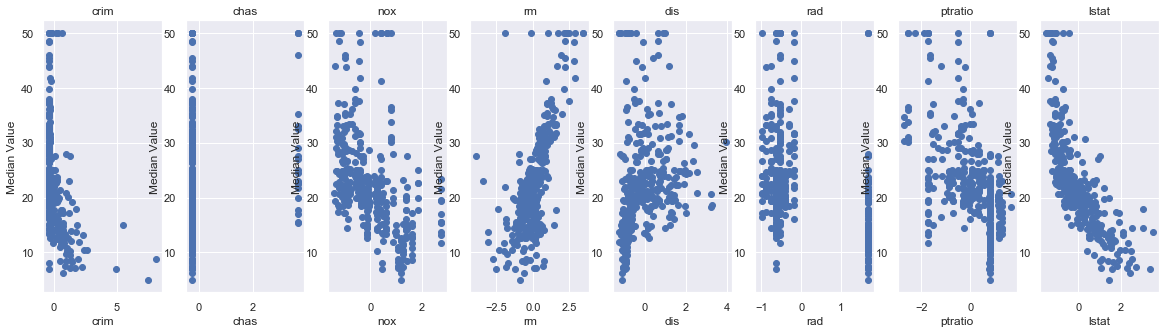

In [331]:
## Now lets do model building

# We will proceed with 8 variables based on selection from our various feature selection tests
# crim, zn, chas, rm, dis, rad, ptratio, lstat and remove the rest
X = df.drop(['indus', 'tax', 'zn', 'age', 'b', 'medv'], axis=1)
Y = df['medv']

# Also since our X variables are on different scales, we will standardize them to bring them on the same measurement scale.
X_column_names = X.columns # Get column names first
scaler = StandardScaler() # Create the Scaler object
X = scaler.fit_transform(X) #Fit your data on the scaler object
X = pd.DataFrame(X, columns= X_column_names)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 15)

# We will look at marginal relationship between various independent variables against dependent variable Medv
plt.figure(figsize=(20, 5))
for i, col in enumerate(x_train.columns):
    plt.subplot(1, 8, i+1) # 8 plots here hence 1, 8
    plt.scatter(x_train[col], y_train)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Median Value')
plt.show()

In [332]:
# Regress Linear function using Statsmodel library
lrmodel = sm.OLS(y_train, sm.add_constant(x_train)).fit()
lrmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     120.1
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           6.71e-95
Time:                        15:45:39   Log-Likelihood:                -1051.5
No. Observations:                 354   AIC:                             2121.
Df Residuals:                     345   BIC:                             2156.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5088      0.255     88.374      0.000      22.008      23.010
crim          -0.7321      0.378     -1.939      0.053      -1.475       0.011
chas           0.6640      0.279      2.378      0.018       0.115       1.213
nox           -2.8241      0.474     -5.957      0.000      -3.757      -1.892
rm             2.5225      0.333      7.569      0.000       1.867       3.178
dis           -2.7114      0.416     -6.514      0.000      -3.530      -1.893
rad            1.3724      0.421      3.262      0.001       0.545       2.200
ptratio       -2.4812      0.320     -7.762      0.000      -3.110      -1.852
lstat         -4.2845      0.401    -10.693      0.000      -5.073      -3.496
==============================================================================
Omnibus:                      110.077   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.771
Skew:                           1.369   Prob(JB):                     1.87e-81
Kurtosis:                       7.208   Cond. No.                         4.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [333]:
# Based on the above summary statistics, we see all variables are statistically significant with their pvalues < 0.05
# Now we will check if they are correalated to each other
# We will test multicollinearity using VIF and graphically as well

x_variables = lrmodel.model.exog # this is the same as x_train
vif = pd.DataFrame()
vif["Variable"] = lrmodel.model.exog_names
vif["VIF Factor"] = [variance_inflation_factor(x_variables, i) for i in range(x_variables.shape[1])]
vif.round(2)
# As per the table below, we see there is no multicollinearity among any of the variables

,Variable,VIF Factor
0,const,1.01
1,crim,1.85
2,chas,1.05
3,nox,3.44
4,rm,1.76
5,dis,2.52
6,rad,2.74
7,ptratio,1.60
8,lstat,2.48


In [334]:
# Lets see if the residuals are normally distributed
df_train = pd.concat([x_train, y_train], axis=1)
lrmodel_fittedy = lrmodel.fittedvalues  # Y fitted values
lrmodel_residuals = lrmodel.resid # lrmodel_residuals = (Y fitted - Y actual value)

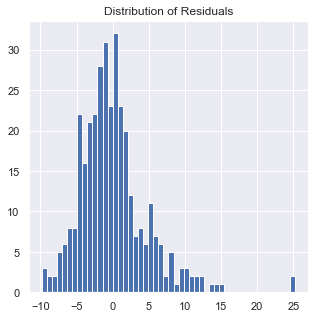

In [335]:
# Lets see if the residuals are normally distributed
lrmodel_residuals.hist(bins=50, figsize=(5,5))
plt.title("Distribution of Residuals")
plt.show()

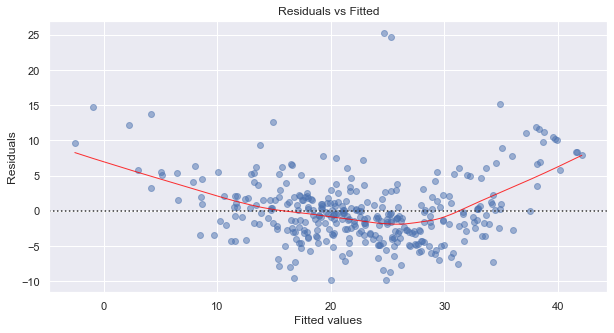

In [336]:
## Check constant variance of the residuals vs fitted values
## Create Residual plot
sns.residplot(lrmodel_fittedy, lrmodel_residuals, data = df_train, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [337]:
# Since the residual plots display heteroskedasticity we will try log transformation of Y variable and replot.
ylog_train = np.log(y_train)
ylog_train.head(3)

129    2.660260
349    3.280911
257    3.912023
Name: medv, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     155.3
Date:                Thu, 27 Feb 2020   Prob (F-statistic):          1.91e-109
Time:                        15:45:40   Log-Likelihood:                 86.927
No. Observations:                 354   AIC:                            -155.9
Df Residuals:                     345   BIC:                            -121.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0331      0.010    296.832      0.0

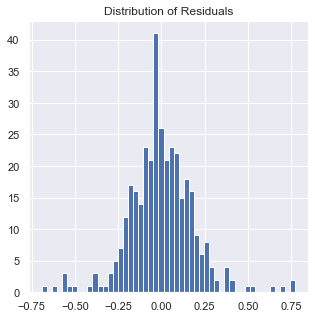

In [338]:
# Regress Linear function using Statsmodel library
df_train = pd.concat([x_train, ylog_train], axis=1)
lrmodel = sm.OLS(ylog_train, sm.add_constant(x_train)).fit()
print(lrmodel.summary())
lrmodel_fittedy = lrmodel.fittedvalues
lrmodel_residuals = lrmodel.resid

lrmodel_residuals.hist(bins=50, figsize=(5,5))
plt.title("Distribution of Residuals")
plt.show()

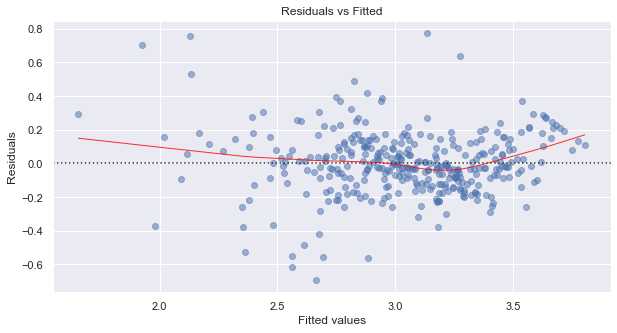

In [339]:
sns.residplot(lrmodel_fittedy, lrmodel_residuals, data = df_train, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

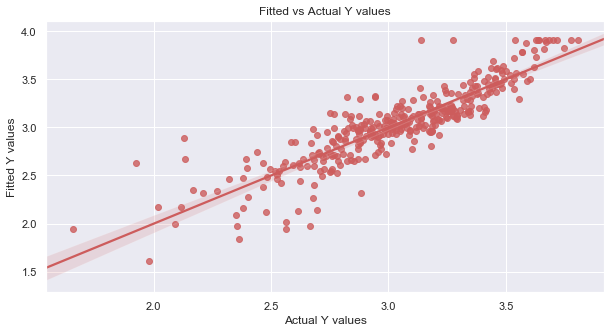

In [340]:
# Check linearity of regression plot Actual Y vs Fitted Y
df_resid = pd.concat([lrmodel_fittedy, ylog_train], axis=1)
sns.regplot(lrmodel_fittedy, ylog_train, data=df_resid, color='indianred')
plt.title('Fitted vs Actual Y values')
plt.xlabel('Actual Y values')
plt.ylabel('Fitted Y values')
plt.show()

In [341]:
#Transforming X variables using Power Transformation, Box-Cox is for positive values only and Yeo-Johnson can be used for both + and - values
pt = PowerTransformer(method='yeo-johnson') 
x_train_pt = pt.fit_transform(x_train) # Fit the data to the powertransformer and Transform the data 
x_train_pt = pd.DataFrame(data = x_train_pt) #Pass the transformed data into a new dataframe because pt.transform returns an array
x_train_pt.head(3)

,0,1,2,3,4,5,6,7
0,-0.196605,-0.251124,0.730020,-0.921497,-0.981147,-0.646692,1.641116,0.937042
1,-0.809411,-0.251124,-1.271121,0.914861,1.845864,-1.796710,0.463985,-1.041683
2,-0.375147,-0.251124,0.888179,3.227928,-1.144124,-0.341338,-1.883023,-1.218990


In [342]:
# After power transformation the index and columns are reset to default
# So we need to change it bacl to original to align with out original x_train dataset index and column to be able to regress

x_train_pt.index = x_train.index  # Reindex X index
x_train_pt.columns = x_train.columns # Reindex X columns names to original variable names

# Now we can run the linear regression model again to check if trasnformed X variables improved the non-constant variance in residual plot
df_train = pd.concat([x_train_pt, ylog_train], axis=1)
lrmodel = sm.OLS(ylog_train, sm.add_constant(x_train_pt)).fit()
print(lrmodel.summary())
lrmodel_fittedy = lrmodel.fittedvalues
lrmodel_residuals = lrmodel.resid

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     139.9
Date:                Thu, 27 Feb 2020   Prob (F-statistic):          2.07e-103
Time:                        15:45:42   Log-Likelihood:                 72.594
No. Observations:                 354   AIC:                            -127.2
Df Residuals:                     345   BIC:                            -92.36
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0381      0.011    286.296      0.0

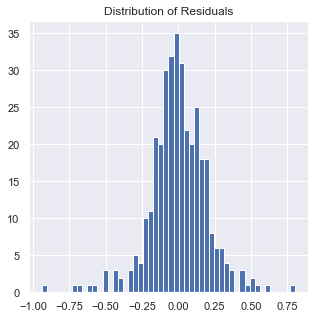

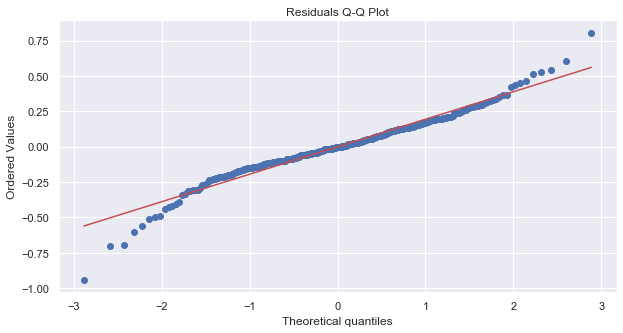

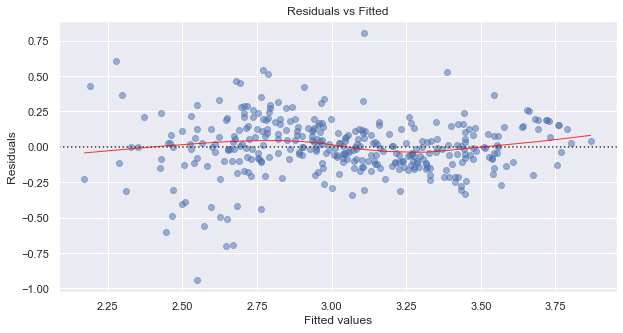

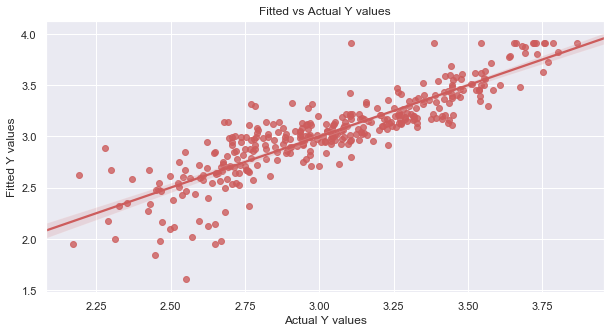

In [343]:
# Lets look at all our new plots
# Histogram to check normal distribtuion of residuals
lrmodel_residuals.hist(bins=50, figsize=(5,5))
plt.title("Distribution of Residuals")
plt.show()

# QQ plot
stats.probplot(lrmodel_residuals, dist="norm", plot= plt)
plt.title("Residuals Q-Q Plot")
plt.show()

# Residual plot to constant variance of residuals
sns.residplot(lrmodel_fittedy, lrmodel_residuals, data = df_train, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Check linearity of regression plot Actual Y vs Fitted Y
df_resid = pd.concat([lrmodel_fittedy, ylog_train], axis=1)
sns.regplot(lrmodel_fittedy, ylog_train, data=df_resid, color='indianred')
plt.title('Fitted vs Actual Y values')
plt.xlabel('Actual Y values')
plt.ylabel('Fitted Y values')
plt.show()

In [344]:
# Next check other tests like Bruesh Pgan, shapiro wilk etc from your notes, cooks distance
 # And plot scatter plots of y fitted against each variable

# Plot partial regression plots now
# Do F test to check combined significance


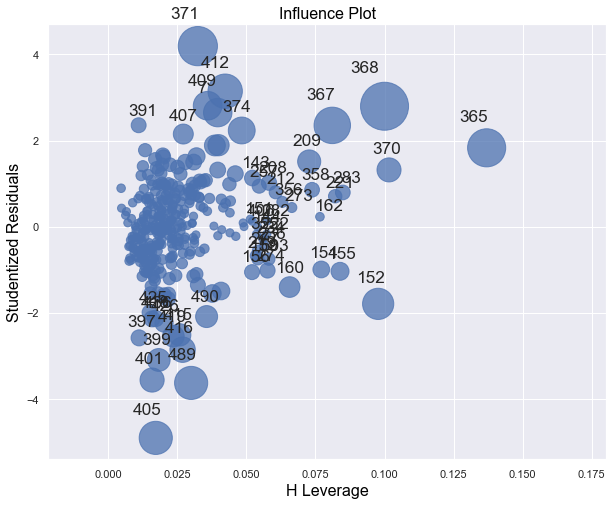

In [345]:
# Plotting Cook's distance to find leverage and influential pints
fig, ax = plt.subplots(figsize=(10,8))
fig = sm.graphics.influence_plot(lrmodel, alpha = 0.05, ax=ax, criterion="cooks")

#infl = lrmodel.get_influence() # to get influence and cooks val for each data
#sm_fr = infl.summary_frame()
#sm_fr

In [346]:
# Normality of residuals can be tested using Kolmogorov-Smirnov test, Jarque–Bera test, or the Shapiro-Wilk test
# Here we will use Jarque–Bera test
test_labels = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
jbera_test = sm.stats.jarque_bera(lrmodel.resid)
lzip(test_labels, jbera_test)

[('Jarque-Bera', 131.9746111966057),
 ('Chi^2 two-tail prob.', 2.1982511194535947e-29),
 ('Skew', -0.3135713696091114),
 ('Kurtosis', 5.924743279710606)]

In [347]:
# Heteroskedasticity can be due to omitted X variables, outliers or leverage present in the data
# Homoscedasticity of residuals can be tested using Bruesch-Pagan, Cook-Weisberg test, or White general test, Spearman’s rank correlation test
# Here we will use Breusch Pagan test
test_labels = ['Breusch Pagan stat', 'LM p-value', 'F statistic', 'F test p-value']
bpagan_test = het_breuschpagan(lrmodel.resid, lrmodel.model.exog)
lzip(test_labels, bpagan_test)

[('Breusch Pagan stat', 58.33820821932302),
 ('LM p-value', 9.86315077135642e-10),
 ('F statistic', 8.509165876003893),
 ('F test p-value', 1.3987774944444536e-10)]

In [348]:
white_test = het_white(lrmodel.resid,  lrmodel.model.exog)
lzip(test_labels, white_test)

[('Breusch Pagan stat', 105.55559907036496),
 ('LM p-value', 3.5505908489968527e-07),
 ('F statistic', 3.062988028744694),
 ('F test p-value', 9.921572133393924e-09)]

In [349]:
# Test for Auto Correlation of Residuals
test_labels = ['Breusch Godfrey stat', 'LM p-value', 'F statistic', 'F test p-value']
bgodfrey_test = sm.stats.diagnostic.acorr_breusch_godfrey(lrmodel)
lzip(test_labels, bgodfrey_test)

[('Breusch Godfrey stat', 11.139233341323202),
 ('LM p-value', 0.8008106675858108),
 ('F statistic', 0.6679540343604573),
 ('F test p-value', 0.8252701956512151)]

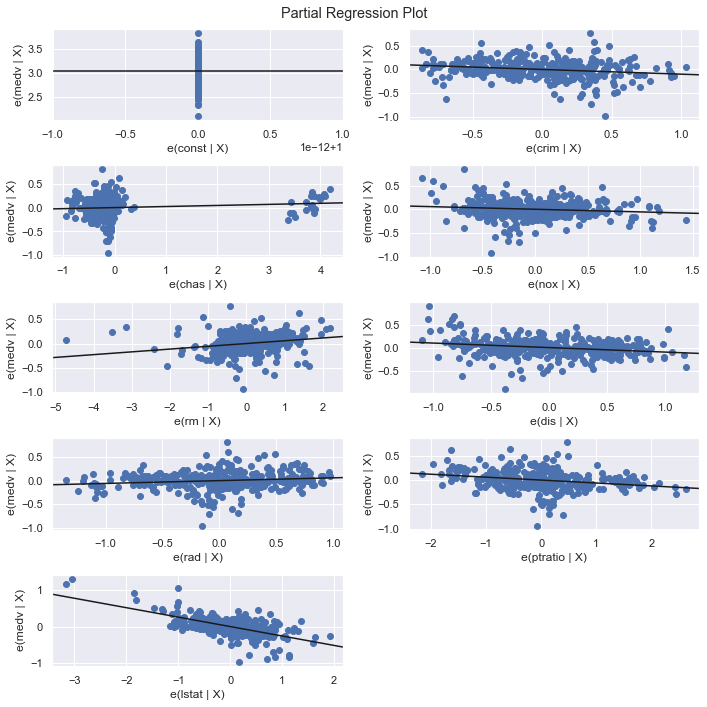

In [350]:
# For a quick check of all the regressors, you can use plot_partregress_grid. These plots will not label the points, 
# but we can use them to identify problems and then use plot_partregress to get more information.
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(lrmodel, fig=fig)

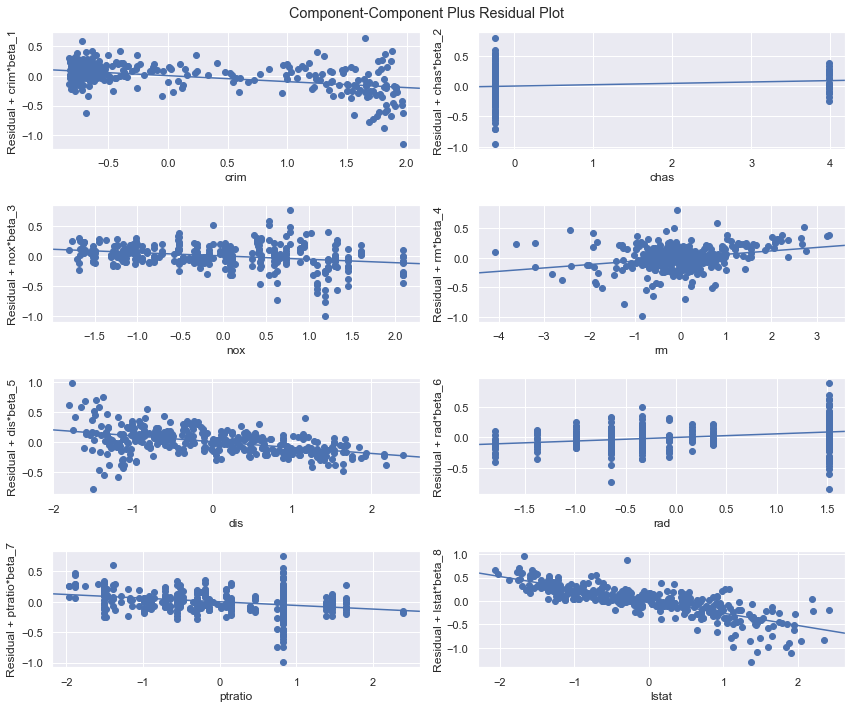

In [351]:
# The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other
# independent variables. The partial residuals plot is defined as Residuals + BiXi versus Xi
fig = plt.figure(figsize=(12, 12))
fig = sm.graphics.plot_ccpr_grid(lrmodel, fig=fig)

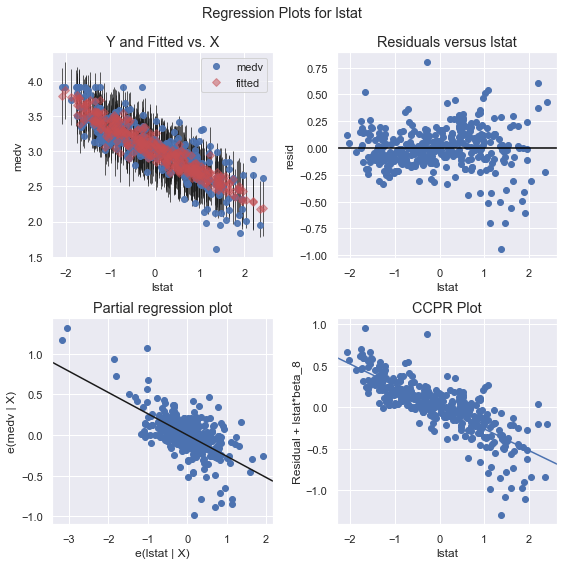

In [352]:
# Based on the coefficients in the summary above, variables crim (Crime rate), ptartio (pupil to teacher ratio),
# rm (number of rooms) and lstat (lower status households) have more impact on the target variable medv (median value of house).
# So we will inspect regression plots, using these variables only.

#The below figure produces four regression plots for lstat
fig = plt.figure(figsize=(8, 8))
# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(lrmodel, "lstat", fig=fig)

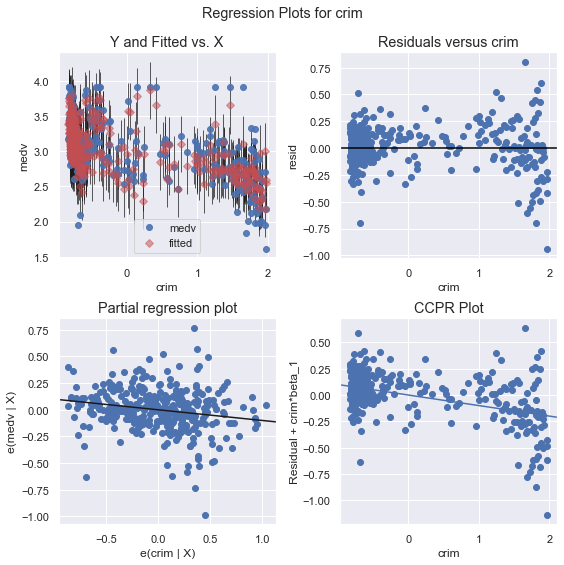

In [353]:
#The below figure produces four regression plots for crim
fig = plt.figure(figsize=(8, 8))
# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(lrmodel, "crim", fig=fig)

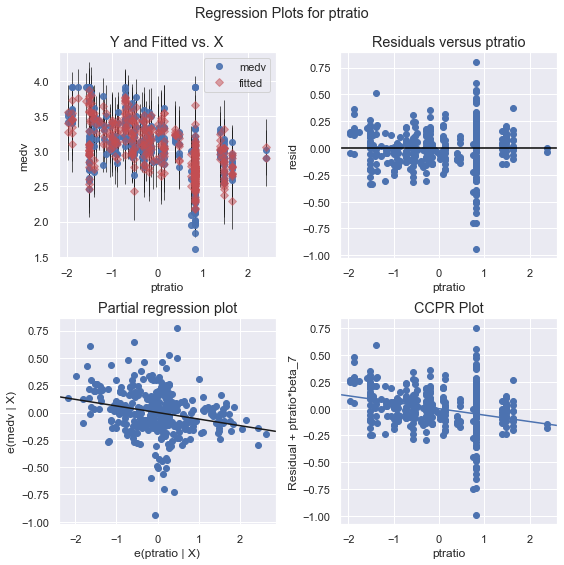

In [354]:
#The below figure produces four regression plots for ptratio
fig = plt.figure(figsize=(8, 8))
# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(lrmodel, "ptratio", fig=fig)

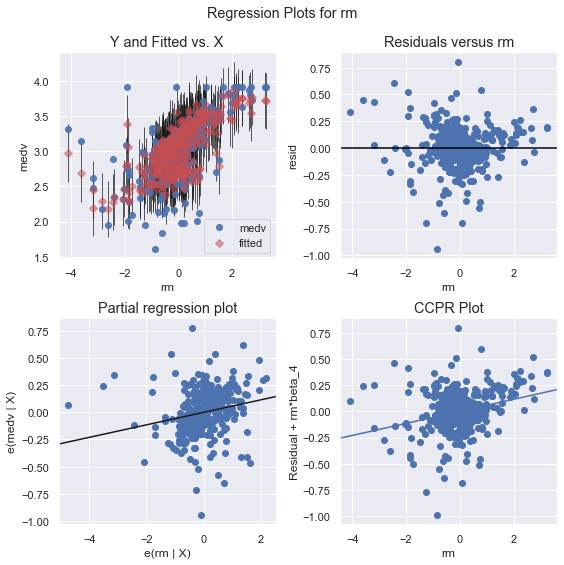

In [355]:
#The below figure produces four regression plots for rm
fig = plt.figure(figsize=(8, 8))
# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(lrmodel, "rm", fig=fig)

In [356]:
#Transforming test sample: X variables using Power Transformation and Y using log transformation

x_test_pt = pt.fit_transform(x_test)
x_test_pt = pd.DataFrame(data = x_test_pt)
x_test_pt.index = x_test.index
x_test_pt.columns = x_test.columns

# Log transforming Y Test data
ylog_test = np.log(y_test)

In [357]:
#lrmodel = lm.LinearRegression()
#lrmodel = lrmodel.fit(x_train_pt, ylog_train)
#y_pred = lrmodel.predict(x_test_pt)
#y_pred = pd.DataFrame(y_pred)
#y_pred.head()

# fit a model
#lrrmodel = sm.OLS(ylog_train, sm.add_constant(x_train_pt)).fit()
x_test_pt = sm.add_constant(x_test_pt)
y_pred = lrmodel.predict(x_test_pt)
y_pred.head(3)

301    3.293389
262    3.605774
172    3.011034
dtype: float64

In [358]:
## Next we want to compare y_test with y_pred to see how far off the predictions are
#comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
comparison = pd.DataFrame({'Actual': ylog_test, 'Predicted': y_pred})
comparison.head()

,Actual,Predicted
301,3.091042,3.293389
262,3.887730,3.605774
172,3.139833,3.011034
505,2.476538,3.109736
111,3.126761,3.273290


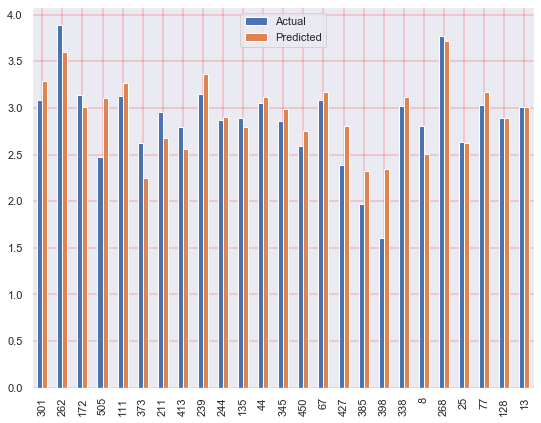

In [359]:
# We can also visualize comparison result as a bar graph. We will use 25 values
bar_chart = comparison.head(25)
bar_chart.plot(kind='bar',figsize=(9,7))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='blue')
plt.show()

In [360]:
## We test the model's accuracy by looking at the difference between predicted values and actual values
## An accurate model would have residuals of zero. For regression algorithms, evaluation metrics commonly used are: MSE, MAE and RSME

mae = metrics.mean_absolute_error(ylog_test, y_pred)
mse = metrics.mean_squared_error(ylog_test, y_pred)
rmse = np.sqrt(mse)
Prediction_Accuracy = lrmodel.rsquared

print("Mean Absolute Error is", round(mae, 2))
print("Mean Squared Error is", round(mse, 2))
print("Root Mean Squared Error is", round(rmse, 2))
print("Prediction Accuracy: %.2f%%" % (Prediction_Accuracy*100.0))

Mean Absolute Error is 0.17
Mean Squared Error is 0.05
Root Mean Squared Error is 0.22
Prediction Accuracy: 76.43%
